In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from nice.model.model import NiceModel

from experiments.test_functions import u1
import torch

In [4]:
import numpy as np
import torch
import random

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

(1000000,)


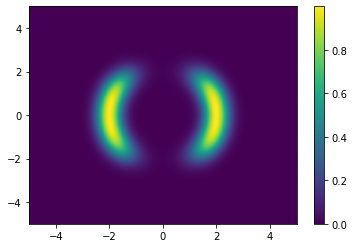

In [5]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kde
 
# create data
size = 5
 
nbins = 1000
xi, yi = np.mgrid[-size:size:nbins*1j, -size:size:nbins*1j]

wi = torch.Tensor(np.vstack([xi.flatten(), yi.flatten()]))
# zi = u1()
zi = u1(wi).detach().numpy()
print(zi.shape)
# Change color palette
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
plt.colorbar()
plt.show()

In [6]:
from nice.model.model import NiceModel
from flows.embedding.basic import Basic
from nice.layer.nice_ortho import NiceOrthogonal

k = 2
dims = 2
embedding = Basic(dims)
transforms = [NiceOrthogonal(dims, dims//2, k, dims)]

model = NiceModel(
    embedding=embedding,
    transforms=transforms
)

In [7]:
model(torch.tensor([1,1])).sample()

tensor([[-0.2261, -1.2208]])

In [8]:
from flows.loss.elbo import FlowELBO
from tqdm.notebook import tqdm

batch_size = 64
args = {}


In [9]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00001, momentum=0.9)


In [10]:
NUM_PARAMETERS = sum(p.numel() for p in model.parameters())
print("Number of parameters:", NUM_PARAMETERS)

Number of parameters: 19


  0%|          | 0/26316 [00:00<?, ?it/s]

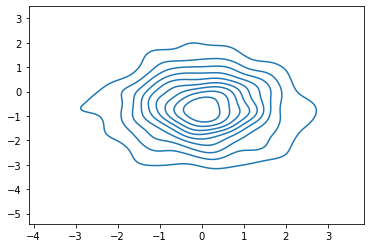

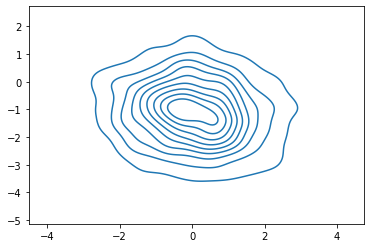

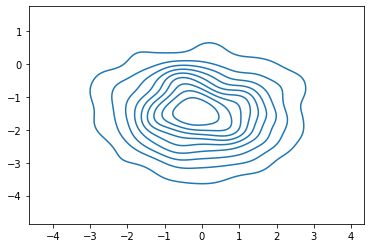

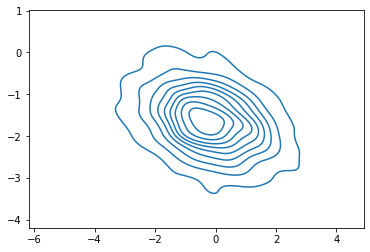

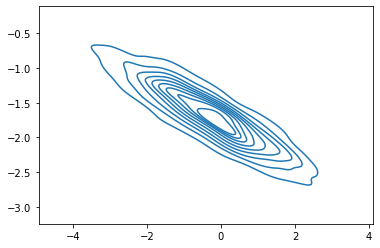

ValueError: Expected parameter covariance_matrix (Tensor of shape (2, 2)) of distribution MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[1.0698, 0.6070],
        [0.6070, 0.3440]], grad_fn=<ExpandBackward0>)

In [11]:

import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(f"runs/nice_ortho_seed={SEED}")

NUM_STEPS = int(np.ceil(500000 / NUM_PARAMETERS))
pbar = tqdm(range(NUM_STEPS))
for step in pbar:
    optimizer.zero_grad()
    loss = FlowELBO(u1, model(torch.tensor([1,1])), num_samples=100, epoch=step)
    pbar.set_postfix_str("loss: " + '{0:.2f}'.format(loss.item()))
    loss.backward()
    writer.add_scalar("_loss", loss.item(), step * NUM_PARAMETERS)
    writer.add_scalar("embedding_mean_magnitude", torch.norm(torch.abs(model.embedding.mean)).item(), step * NUM_PARAMETERS)
    writer.add_scalar("embedding_covariance_determinant", torch.det(model.embedding.cov).item(), step * NUM_PARAMETERS)
    optimizer.step()
    if step % 2000 == 0:
        samples = model(torch.tensor([1,1])).sample((1000,)).detach()
        sns.kdeplot(x=samples[:,0].detach().numpy(), y=samples[:,1].detach().numpy())
        plt.show()
    # print("{: >5d}\t{}".format(step, loss ))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

samples = model(torch.tensor([1,1])).sample((1000,))
print(samples.shape)
sns.kdeplot(samples[:,0].detach().numpy(), samples[:,1].detach().numpy())
plt.show()

In [ ]:
list(model.named_parameters())

In [ ]:
# we can't just call log_prob on an artbitary vector
# since it doesn't have a anlytic solution
# and uses cache to compute the log_prob

samples = model(torch.tensor([1,1])).sample((1000,))
log_probs = model(torch.tensor([1,1])).log_prob(samples).detach().numpy()
probs = np.exp(log_probs)
xs = samples[:,0].detach().numpy()
ys = samples[:,1].detach().numpy()
plt.scatter(xs,ys, c=probs.reshape(xs.shape), cmap='turbo', marker='.')
plt.colorbar()
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()